In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import tensorflow as tf

%matplotlib inline

## Алгоритм кластеризации K-means


Алгоритм k-means применяется для задачи кластеризации. Напомню его основные шаги. Пусть у нас имеется N точек на плоскости ${(x_1,y_1),...,(x_N,y_N)}$
Допустим мы хотим разбить их на k=3 кластера.
1. Выбираем k=3 случайные точки из этого множества. Говорим, что они являются теперь центрами наших кластеров.
2. Для каждой из оставшихся точек смотрим, к какому из центров она ближе и определяем её в этот кластер.
3. У нас получилось разбить точки на 3 кластера. Естественно это не оптимальное разбиение. Найдём новые центры кластеров. Например, если точки ${(x_{i_1}, y_{i_1}),...,(x_{i_n}, y_{i_n})}$ попали в один кластер, то их новый центр будет имеет координаты:
$$x_M=\frac{x_{i_1}+...+x_{i_n}}{n}$$
$$y_M=\frac{y_{i_1}+...+y_{i_n}}{n}$$
4. Переходим к шагу 2 и продолжаем до тех пор, пока кластеры не перестанут меняться.

### Подготовка датасета
Сгенерируем 3 кластера случайных точек, в каждом кластере по 20 точек.
Для этого зафиксируем центры кластеров. Будем генерировать рандомные точки с заданным отклонением вокруг них.

In [ ]:
points = []

num_clusters = 3
cluster_size = 20

means_x = [1., 1.2, 0.8]
means_y = [0.5, 0.6, 0.5]
std = 0.1

for k in range(num_clusters):
    for i in range(cluster_size):
        x_i = np.random.normal(loc=means_x[k], scale=std)
        y_i = np.random.normal(loc=means_y[k], scale=std)
        points.append((x_i, y_i))

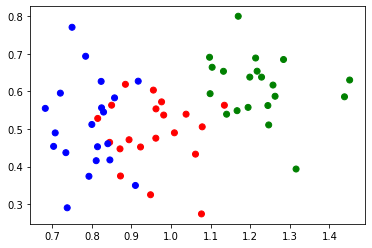

In [ ]:
points_x = list(map(lambda x: x[0], points))
points_y = list(map(lambda x: x[1], points))
colors = ['r'] * cluster_size + ['g'] * cluster_size + ['b'] * cluster_size
plt.scatter(x=points_x, y=points_y, c=colors)

In [ ]:
def k_means(points, num_clusters):
    """
    @param points: список из пар координат точек
    @param num_clusters: число кластеров, на которое необходимо поделить

    @return: номера кластеров и их центры
    """
    def print_clusters(n_iteration, points, result=None):
      print(f"Итерация №{n_iteration}")
      points_x = list(map(lambda x: x[0], points))
      points_y = list(map(lambda x: x[1], points))
      plt.scatter(x=points_x, y=points_y, c=result)
      plt.show()
    
    num_points = len(points)
    centers = points[:num_clusters] # Выбираем начальные центры кластеров (просто первые num_clusters точек)
    result = [-1] * num_points # В качестве результата будет массив с номерами кластеров для каждой точки
    prev_result = None # Предыдущая копия массива result, чтобы сравнивать, поменялось что-то или нет
    
    print_clusters(0, points) # Выведем на экран стартовую ситуацию
    
    n_iteration = 1

    # Работаем до тех пор, пока кластеры не перестанут меняться

    while result != prev_result:
        prev_result = list(result)

        # Определяем каждую точку к кластеру

        for j, (x, y) in enumerate(points):
            dist = [np.sqrt((x-x1)**2 + (y-y1)**2) for (x1, y1) in centers]
            result[j] = dist.index(min(dist))
        
            
        # Меняем центры кластеров

        for j in range(num_clusters):
          centers[j] = (np.mean([points[i][0] for i in range(len(points)) if result[i] == j]),\
                        np.mean([points[i][1] for i in range(len(points)) if result[i] == j])) 
            
        print_clusters(n_iteration, points, result) # Выведем то, что у нас получилось
        n_iteration += 1
        
    return result, centers    

Итерация №0


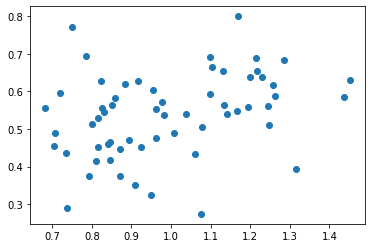

Итерация №1


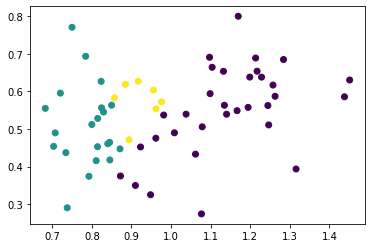

Итерация №2


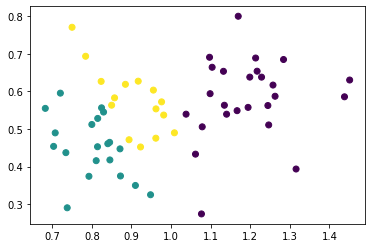

Итерация №3


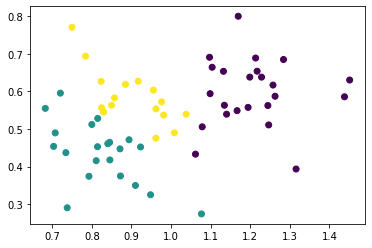

Итерация №4


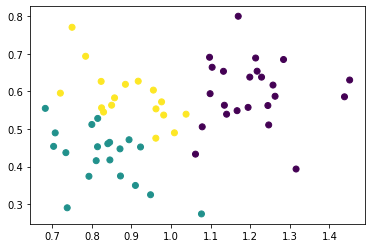

Итерация №5


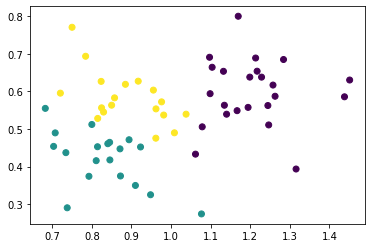

Итерация №6


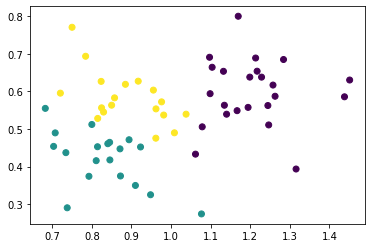

In [ ]:
res, centers = k_means(points, 3)

In [ ]:
print("Истинные центры кластеров:")
for i in range(num_clusters):
    print("({0:.1f}, {1:.1f})".format(means_x[i], means_y[i]))

print("Полученные центры кластеров. Порядок может поменяться, а значения могут немного отличаться:")
for i in range(num_clusters):
    print("({0:.1f}, {1:.1f})".format(centers[i][0], centers[i][1]))

Истинные центры кластеров:
(1.0, 0.5)
(1.2, 0.6)
(0.8, 0.5)
Полученные центры кластеров. Порядок может поменяться, а значения могут немного отличаться:
(1.2, 0.6)
(0.8, 0.4)
(0.9, 0.6)


# практика

In [ ]:
import matplotlib.pyplot as plt
import cv2
from sklearn.cluster import KMeans

In [ ]:
def draw_picture(image, bgr=False):
    b, g, r = cv2.split(image) # по умолчанию cv2 почему-то отдает цвета в порядке BGR вместо RGB
    new_image = cv2.merge([r, g, b])
    plt.figure(figsize=(7, 5))
    plt.axis('off')
    plt.imshow(new_image)
    plt.show()


# заменяем цвета картинки на средние цвета кластеров

def pred_transform(y_pred, cluster_centers):
  a = np.zeros((y_pred.shape[0], 3))
  
  for i in np.arange(y_pred.shape[0]):
    a[i, :] = cluster_centers[y_pred[i]]
  
  return a.astype(np.int)

# преобразуем картинку, отрисовываем

def draw_reduce_image_KMeans(img, clusters=10):
  img_data = img.flatten().reshape((img.shape[0]*img.shape[1], 3))
  
  model = KMeans(n_clusters=clusters)
  y_pred = model.fit_predict(img_data)
  
  img_1 = pred_transform(y_pred, cluster_centers= model.cluster_centers_)

  new_img = img_1.reshape((img.shape[0], img.shape[1], 3))

  draw_picture(new_img)

In [ ]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.datasets import fetch_lfw_people
lfw_people = fetch_lfw_people(min_faces_per_person=50, resize=1.0)

In [ ]:
from sklearn.model_selection import train_test_split
X = lfw_people.data
y = lfw_people.target
names = lfw_people.target_names

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

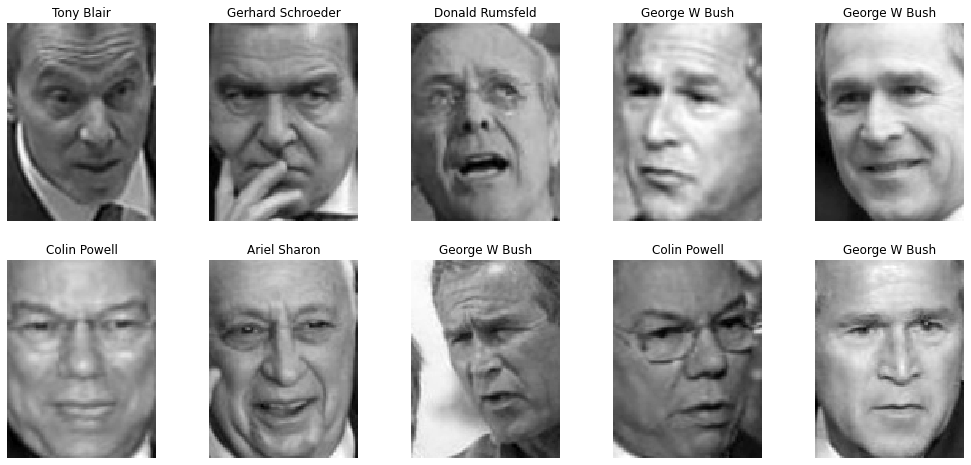

In [ ]:
import matplotlib.pyplot as plt

def plot_image(image_id):
    # функция рисует изображение номер image_id
    plt.title(names[y[image_id]])
    plt.imshow(255 - lfw_people['images'][image_id], cmap=plt.cm.gray_r, interpolation='nearest')

def plot_image_reduced(image_id, n_clusters):
    # функция рисует изображение по матрице значений
    matrix = reduce_image_KMeans_uncolored(lfw_people['images'][image_id], clusters=n_clusters)
    plt.title(names[y[image_id]])
    plt.imshow(255 - matrix, cmap=plt.cm.gray_r, interpolation='nearest')
    
def plot_grid(image_ids, nrows, ncols):
    # функция рисует изображения с id равными image_ids
    # в nrows рядов и ncols столбцов
    fig = plt.gcf()
    fig.set_size_inches(17.5, 8)
    for index, example_id in enumerate(image_ids):
        plt.subplot(nrows, ncols, index + 1)
        plot_image(example_id)
        plt.axis('off')

plot_grid(range(10), nrows=2, ncols=5)# первые 10 лиц

In [ ]:
from sklearn.metrics import accuracy_score

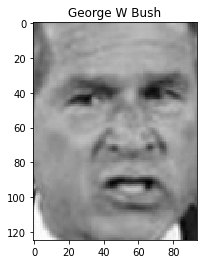

In [ ]:
#вывести одну картинку
plot_image(14)

In [ ]:
# reduce для черно белой картинки

def pred_transform_uncolored(y_pred, cluster_centers):
  a = np.zeros((y_pred.shape[0], 1))
  
  for i in np.arange(y_pred.shape[0]):
    a[i, :] = cluster_centers[y_pred[i]]
  
  return a.astype(np.int)

def reduce_image_KMeans_uncolored(img, clusters=10):
  img_data = img.flatten().reshape(-1, 1)
  
  model = KMeans(n_clusters=clusters)
  y_pred = model.fit_predict(img_data)
  
  img_1 = pred_transform_uncolored(y_pred, cluster_centers= model.cluster_centers_)

  new_img = img_1.reshape((img.shape[0], img.shape[1]))

  return new_img

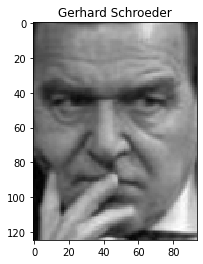

In [ ]:
plot_image(1)

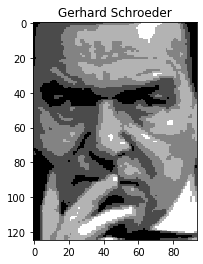

In [ ]:
plot_image_reduced(1, 5)

In [ ]:
#redo with open('/content/drive/MyDrive/числ методы/test.npy', 'rb') as f:
    #a = np.load(f)

### создаем обработанные картинки

In [ ]:
X_new = X.copy()


(1560, 11750)

In [ ]:
for i in np.arange(X.shape[0]):
  if i % 300 == 0 : print(i)
  X_new[i] = reduce_image_KMeans_uncolored(lfw_people['images'][i], clusters=5).flatten()

In [ ]:
from tempfile import TemporaryFile
outfile = TemporaryFile()

np.save(outfile, X_new)

_ = outfile.seek(0) # Only needed here to simulate closing & reopening file
np.load(outfile)

with open('test.npy', 'wb') as f:
    np.save(f, X_new)
with open('test.npy', 'rb') as f:
    a = np.load(f)

a"""

array([[ 79.,  79.,  79., ..., 168., 129., 101.],
       [ 39.,  39.,  39., ..., 150., 150., 150.],
       [ 89.,  89.,  89., ...,  57.,  57.,  89.],
       ...,
       [ 58.,  58.,  58., ..., 173., 173., 114.],
       [126., 126., 160., ..., 231., 231., 231.],
       [ 41.,  41.,  41., ...,  41.,  81.,  81.]], dtype=float32)

In [ ]:
def plot_image_a(image_id):
    # функция рисует изображение номер из переделанного image_id
    plt.title(names[y[image_id]])
    plt.imshow(255 - a[image_id].reshape((125, 94)), cmap=plt.cm.gray_r, interpolation='nearest')

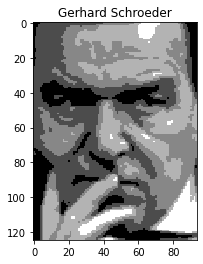

In [ ]:
plot_image_a(1)

In [ ]:
a.shape

(1560, 11750)

a - датасет с произведенной кластеризацией

X - датасет без кластеризации

In [ ]:
a = a.reshape((1560, 125, 94, 1))

In [ ]:
X = X.reshape((1560, 125, 94, 1))

#### start here

In [ ]:
from IPython.display import display
w = widgets.IntSlider(10, min=1, max=20, description='Eposchs')
display(w)

IntSlider(value=10, description='Eposchs', max=20, min=1)

In [ ]:
n1 = 8
n2 = 16

In [ ]:
X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(a, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
# Model / data parameters
num_classes = len(set(y))
input_shape = (125, 94, 1)

X_train = X_train
X_test = X_test
y_train = y_train
y_test = y_test

# Scale images to the [0, 1] range
X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255

print("x_train shape:", X_train.shape)
print(X_train.shape[0], "train samples")
print(X_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (1248, 125, 94, 1)
1248 train samples
312 test samples


In [ ]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(n1, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(n2, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_54 (Conv2D)           (None, 123, 92, 8)        80        
_________________________________________________________________
max_pooling2d_54 (MaxPooling (None, 61, 46, 8)         0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 59, 44, 16)        1168      
_________________________________________________________________
max_pooling2d_55 (MaxPooling (None, 29, 22, 16)        0         
_________________________________________________________________
flatten_27 (Flatten)         (None, 10208)             0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 10208)             0         
_________________________________________________________________
dense_27 (Dense)             (None, 12)              

In [ ]:
batch_size = 128
epochs = w.value

with tf.device('/GPU:0'):
  # Compile the model
  model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

  # Train the model
  model.fit(X_train, y_train, batch_size=128, epochs=epochs)

Epoch 1/10
10/10 [==============================] - 1s 19ms/step - loss: 0.0726 - accuracy: 0.2642
Epoch 2/10
10/10 [==============================] - 0s 17ms/step - loss: 0.0693 - accuracy: 0.3305
Epoch 3/10
10/10 [==============================] - 0s 14ms/step - loss: 0.0692 - accuracy: 0.3155
Epoch 4/10
10/10 [==============================] - 0s 14ms/step - loss: 0.0652 - accuracy: 0.3743
Epoch 5/10
10/10 [==============================] - 0s 13ms/step - loss: 0.0658 - accuracy: 0.3491
Epoch 6/10
10/10 [==============================] - 0s 13ms/step - loss: 0.0627 - accuracy: 0.4097
Epoch 7/10
10/10 [==============================] - 0s 13ms/step - loss: 0.0583 - accuracy: 0.4442
Epoch 8/10
10/10 [==============================] - 0s 14ms/step - loss: 0.0551 - accuracy: 0.4882
Epoch 9/10
10/10 [==============================] - 0s 14ms/step - loss: 0.0489 - accuracy: 0.5849
Epoch 10/10
10/10 [==============================] - 0s 13ms/step - loss: 0.0446 - accuracy: 0.6242


In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.04572835564613342
Test accuracy: 0.625


## обучение на обработанных картинках

In [ ]:
# Model / data parameters
num_classes = len(set(y))
input_shape = (125, 94, 1)

X_train = X_train_a
X_test = X_test_a
y_train = y_train_a
y_test = y_test_a

# Scale images to the [0, 1] range
X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255

print("x_train shape:", X_train.shape)
print(X_train.shape[0], "train samples")
print(X_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (1248, 125, 94, 1)
1248 train samples
312 test samples


In [ ]:
model_2 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(n1, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(n2, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

In [ ]:
batch_size = 128
epochs = w.value

with tf.device('/GPU:0'):
  # Compile the model
  model_2.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

  # Train the model
  model_2.fit(X_train, y_train, batch_size=128, epochs=epochs)

Epoch 1/10
10/10 [==============================] - 1s 14ms/step - loss: 0.0735 - accuracy: 0.2106
Epoch 2/10
10/10 [==============================] - 0s 13ms/step - loss: 0.0691 - accuracy: 0.3524
Epoch 3/10
10/10 [==============================] - 0s 13ms/step - loss: 0.0686 - accuracy: 0.3430
Epoch 4/10
10/10 [==============================] - 0s 13ms/step - loss: 0.0684 - accuracy: 0.3412
Epoch 5/10
10/10 [==============================] - 0s 13ms/step - loss: 0.0668 - accuracy: 0.3474
Epoch 6/10
10/10 [==============================] - 0s 14ms/step - loss: 0.0641 - accuracy: 0.3883
Epoch 7/10
10/10 [==============================] - 0s 13ms/step - loss: 0.0617 - accuracy: 0.4142
Epoch 8/10
10/10 [==============================] - 0s 14ms/step - loss: 0.0587 - accuracy: 0.4164
Epoch 9/10
10/10 [==============================] - 0s 13ms/step - loss: 0.0538 - accuracy: 0.4942
Epoch 10/10
10/10 [==============================] - 0s 13ms/step - loss: 0.0496 - accuracy: 0.5572


In [ ]:
score = model_2.evaluate(X_test, y_test, verbose=0)
print('Test loss_processed:', score[0])
print('Test accuracy_processed:', score[1])

print()

score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss_processed: 0.04689360037446022
Test accuracy_processed: 0.6185897588729858

Test loss: 0.046285927295684814
Test accuracy: 0.5961538553237915


### для конволюционных моделей с маленьким количеством нейронов уменьшение палитры изображения хорошо влияет на точность т.к. упрощает считывание инофрмации

### для конволюционных моделей с относительно большим количеством нейронов уменьшение цветовой палитры отнимает какую то часть информации о картинке, соответственно уменьшает точность